In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import optuna
import sys
sys.path.append('../')
from utils.prep_dataset import prepare_df
from utils.create_features import stat_features, qty_last_dt
from utils.tools import generate_lightfm_recs_mapper, compute_metrics

In [2]:
# гиперпарамтеры
TOP_CANDIDATES = 30
TOP_FOR_TEST = 200

In [3]:
df = pd.read_csv('../data/prepare_data.csv')

df['user_id'] = df.groupby(['Телефон_new', 'ЭлектроннаяПочта_new']).ngroup()
df = df[(df['Цена'] > 0) & (df['Количество'] > 0)] # оставляем товары, стоимость которых больше 0
df = df.drop_duplicates()
df = df.dropna(subset=['item_name']) # удаляем случаи, когда товары неизветны (посмореть их долю)
df = df.dropna(subset=['user_id']) # удаляем user_id, у которых неизветны айдишники (посмореть их долю)
df['item_id'] = df.groupby(['item_name', 'Группа2']).ngroup() #create item_id
df['user_id'] = df.apply(lambda x: int(x['user_id']), axis=1)

In [4]:
df['date'] = pd.to_datetime(df['date'])
max_date = df['date'].max()

df_1lvl = df[['user_id', 'item_id', 'Количество', 'date']]
df_1lvl['qty'] = df_1lvl.groupby(['user_id', 'item_id', 'date'])['Количество'].transform(sum)
df_1lvl = df_1lvl[['user_id', 'item_id', 'qty', 'date']].drop_duplicates()

<ipython-input-4-ecec696fc2f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1lvl['qty'] = df_1lvl.groupby(['user_id', 'item_id', 'date'])['Количество'].transform(sum)


In [7]:
train = df_1lvl[(df_1lvl['date'] < max_date - pd.Timedelta(days=7))]
test = df_1lvl[(df_1lvl['date'] >= max_date - pd.Timedelta(days=7))]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (328651, 4)
test: (48283, 4)


In [8]:
for_1lvl_date_threshold = train['date'].quantile(q=0.5, interpolation='nearest')
for_1lvl_date_threshold

Timestamp('2017-05-25 00:00:00')

In [9]:
train_1lvl = train[(train['date'] < for_1lvl_date_threshold)]
pred_1lvl = train[(train['date'] >= for_1lvl_date_threshold)]

print(f"train: {train_1lvl.shape}")
print(f"pred: {pred_1lvl.shape}")

train: (161480, 4)
pred: (167171, 4)


In [10]:
train_1lvl['i_qty'] = train_1lvl.groupby(['user_id', 'item_id'])['qty'].transform(sum)
pred_1lvl['i_qty'] = pred_1lvl.groupby(['user_id', 'item_id'])['qty'].transform(sum)

# преобразуем в матрицу user-item-ranting
train_1lvl = train_1lvl[['user_id', 'item_id', 'i_qty']].drop_duplicates()
pred_1lvl = pred_1lvl[['user_id', 'item_id', 'i_qty']].drop_duplicates()

print(f"lfm_train: {train_1lvl.shape}")
print(f"lfm_pred: {pred_1lvl.shape}")

lfm_train: (152434, 3)
lfm_pred: (157064, 3)


<ipython-input-10-b7d9b7d3661c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1lvl['i_qty'] = train_1lvl.groupby(['user_id', 'item_id'])['qty'].transform(sum)
<ipython-input-10-b7d9b7d3661c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_1lvl['i_qty'] = pred_1lvl.groupby(['user_id', 'item_id'])['qty'].transform(sum)


In [11]:
test['i_qty'] = test.groupby(['user_id', 'item_id'])['qty'].transform(sum)
test = test[['user_id', 'item_id', 'i_qty']].drop_duplicates()
# оставляем только теплых пользователей
test = test[test['user_id'].isin(train_1lvl['user_id'].unique())]

<ipython-input-11-fcfa75731c5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['i_qty'] = test.groupby(['user_id', 'item_id'])['qty'].transform(sum)


# **LightFM**

Построение первого уровня модели (отбираем кандидатов). 34528
Для начала преведем данные к формату user_id; item_id; date

In [12]:
# теплые пользователи
pred_1lvl = pred_1lvl[pred_1lvl['user_id'].isin(train_1lvl['user_id'].unique())]

## Обучение LightFM

In [13]:
from lightfm.data import Dataset
from lightfm import LightFM

/Users/mariafar/anaconda3/envs/mlp/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [14]:
dataset = Dataset()
dataset.fit(train_1lvl['user_id'].unique(), train_1lvl['item_id'].unique())

In [15]:
# matrix for training
# to coo matrix, матрица взаимодейтсвий и матрица весов вз
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*train_1lvl[['user_id', 'item_id', 'i_qty']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [16]:
# user / item mappings
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 52619
items_mapping amount: 421


In [17]:
lfm_model = LightFM(
        no_components=64, 
        learning_rate=0.1, 
        loss='warp', 
        max_sampled=5,
        item_alpha=0.48251512013999975,
        user_alpha=0.05416387695577227,
        random_state=42
)

In [18]:
# 💪🏼 train model

num_epochs = 30

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )

  0%|          | 0/30 [00:00<?, ?it/s]

## Генерируем предсказания LightFM как кандидатов для второго этапа

In [19]:
# пустой датафрейм для предсказания
candidates_lghtfm = pd.DataFrame({
    'user_id': pred_1lvl['user_id'].unique()
})\

candidates_lghtfm.head(3)

,user_id
0,107815
1,111502
2,3933


In [20]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, 
                                 user_features, item_features, N, 
                                 user_mapping, item_inv_mapping, 
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, 
                             item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        final_scores = recs[top_cols]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        total_final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
            filter_scores = dict(zip(total_final_recs, final_scores))
            final_scores = [filter_scores[key] for key in final_recs]
        return (final_recs[:N], final_scores[:N])
    return _recs_mapper

In [21]:
# вспомогательные данные 
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=dict(),
    N=TOP_CANDIDATES,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [22]:
candidates_lghtfm['item_id'] = candidates_lghtfm['user_id'].map(mapper)

In [23]:
candidates_lghtfm['item_id'], candidates_lghtfm['lfm_score'] = zip(*candidates_lghtfm.item_id)

In [24]:
candidates_lghtfm = candidates_lghtfm.explode(['item_id', 'lfm_score'])
candidates_lghtfm['lfm_rank'] = candidates_lghtfm.groupby('user_id').cumcount() + 1 

candidates_lghtfm.head()

,user_id,item_id,lfm_score,lfm_rank
0,107815,407,0.000014,1
0,107815,296,0.000009,2
0,107815,342,0.000007,3
0,107815,69,0.000007,4
0,107815,153,0.000007,5


In [25]:
candidates_lghtfm = candidates_lghtfm.reset_index()

In [558]:
candidates_lghtfm.to_csv('../prediction_1lvl_models/top30_candidates_lghtfm.csv', index=False)

## 1) Метрики качества LightFM

In [26]:
# оставляем только теплых пользователей
test = test[test['user_id'].isin(train_1lvl['user_id'].unique())]

In [27]:
# кол-во кандидатов берем больше, чем для обучения
# чтобы катбусту было, что ранжировать
top_N = 200

lfm_prediction = pd.DataFrame({
    'user_id': test['user_id'].unique()
})
all_cols = list(lightfm_mapping['items_mapping'].values())
known_items = train_1lvl.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

lfm_prediction['item_id'] = lfm_prediction['user_id'].map(mapper)
lfm_prediction['item_id'], lfm_prediction['lfm_score'] = zip(*lfm_prediction.item_id)
lfm_prediction = lfm_prediction.explode(['item_id', 'lfm_score'])
lfm_prediction['lfm_rank'] = lfm_prediction.groupby('user_id').cumcount() + 1 

In [560]:
lfm_prediction.to_csv('../prediction_1lvl_models/top200_candidates_lfm.csv', index=False)

In [552]:
lfm_metrics = compute_metrics(test[['user_id', 'item_id']],
                              lfm_prediction, 
                              top_N=10, rank_col='lfm_rank')
lfm_metrics

Precision@1     0.211544
Recall@1        0.094238
Precision@2     0.189785
Recall@2        0.163626
Precision@3     0.131359
Recall@3        0.167831
Precision@4     0.115594
Recall@4        0.183549
Precision@5     0.097129
Recall@5        0.195141
Precision@6     0.087287
Recall@6        0.202572
Precision@7     0.077537
Recall@7        0.208051
Precision@8     0.076496
Recall@8        0.224017
Precision@9     0.069810
Recall@9        0.226979
Precision@10    0.063252
Recall@10       0.227697
MAP@10          0.177067
MRR             0.325530
dtype: float64

# 2️⃣ 2 этап: обучаем бустинг

- Ставим задачу как бинарную классификацию
- Выбираем `CatBoostClassifier`, так как много категориальных признаков candidates

##  Собираем train + target

### 📗 `target = 1` Позитивные взаимодействия = все что пользователь посмотрел из кандидатов lightfm 

In [29]:
pos = candidates_lghtfm.merge(pred_1lvl,
                        on=['user_id', 'item_id'],
                        how='inner')
pos['target'] = 1
print(pos.shape)

(13546, 7)


### 📕 `target = 0` Негативные взаимодействия = все что пользователь НЕ посмотрел из кандидатов lightfm 

- добавим сэмплирование, чтобы соблюсти баланс классов


In [30]:
neg = candidates_lghtfm.set_index(['user_id', 'item_id'])\
        .join(pred_1lvl.set_index(['user_id', 'item_id']))

neg = neg[neg['i_qty'].isnull()].reset_index()

neg = neg.sample(frac=0.1)
neg['target'] = 0

neg.shape

(31141, 7)

## Формируем трейн и тест: ctb_train, ctb_test

### Важно! Делим по пользователям, а не по дате. 

`Мотивация`: 

- Для негативных взаимодействий нет даты
- Проверяем робастность бустинга относительно новых (холодных) пользователей

In [31]:
ctb_train_users, ctb_test_users = train_test_split(pred_1lvl['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [32]:
# выделяем 10% под механизм early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [33]:
select_col = ['user_id', 'item_id', 'lfm_score', 'lfm_rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

In [34]:
ctb_train['target'].value_counts(normalize=True)

0    0.699253
1    0.300747
Name: target, dtype: float64

In [35]:
ctb_test['target'].value_counts(normalize=True)

0    0.687702
1    0.312298
Name: target, dtype: float64

## Формируем фичи 

- формируем признаки для user_id статичные и зависящие от окна 
- как признак также используем `rank` от модели 1 этапа
- заполняем пропуски в данных

In [36]:
stat_user_features, stat_item_features = stat_features(df, df[['user_id']].drop_duplicates())

In [37]:
train_feat = ctb_train.merge(stat_user_features,
                           on=['user_id'],
                           how='left')\
                        .merge(stat_item_features,
                                   on=['item_id'],
                                   how='left')

eval_feat = ctb_eval.merge(stat_user_features,
                           on=['user_id'],
                           how='left')\
                        .merge(stat_item_features,
                                   on=['item_id'],
                                   how='left')

In [537]:
train_feat.shape, ctb_train.shape

((32016, 40), (32016, 5))

### X, y

In [38]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = []

In [39]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [40]:
# fillna for catboost with the most frequent value 
X_train = X_train.fillna(X_train.mode().iloc[0])

In [41]:
# fillna for catboost with the most frequent value 
X_val = X_val.fillna(X_train.mode().iloc[0])

In [ ]:
X_train.shape

## Подбор оптимальных гиперпараметров


In [286]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [287]:
def objective(trial,data=X_train, target=y_train):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [123]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBClassifier(**param, eval_metric='logloss')  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict_proba(test_x)
    
    roc_auc = roc_auc_score(test_y, preds[:, 1])
    return roc_auc

In [160]:
%%time
study = optuna.create_study(direction='maximize', study_name="xgb_tuning")
study.optimize(objective, n_trials=100)

[I 2023-04-23 16:42:58,972] A new study created in memory with name: xgb_tuning
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mariafar/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was e

CPU times: user 3h 57s, sys: 11min 4s, total: 3h 12min 1s
Wall time: 27min 24s


# print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

## Обучение

In [42]:
from xgboost import XGBClassifier

est_params = {
        'lambda': 0.03766383403897379, 
        'alpha': 0.44250252364320947, 
        'colsample_bytree': 0.3, 
        'subsample': 0.7, 
        'learning_rate': 0.01, 
        'n_estimators': 7086, 
        'max_depth': 17, 
        'random_state': 123, 
        'min_child_weight': 6}

xgb_model = XGBClassifier(**est_params)
xgb_model.fit(X_train,
              y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              eval_metric=["error", "logloss"],
              verbose=False,
              early_stopping_rounds=80)

/Users/mariafar/anaconda3/envs/mlp/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/mariafar/anaconda3/envs/mlp/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(alpha=0.44250252364320947, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.03766383403897379,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=17,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=7086, n_jobs=None,
              num_parallel_tree=None, ...)

In [480]:
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px

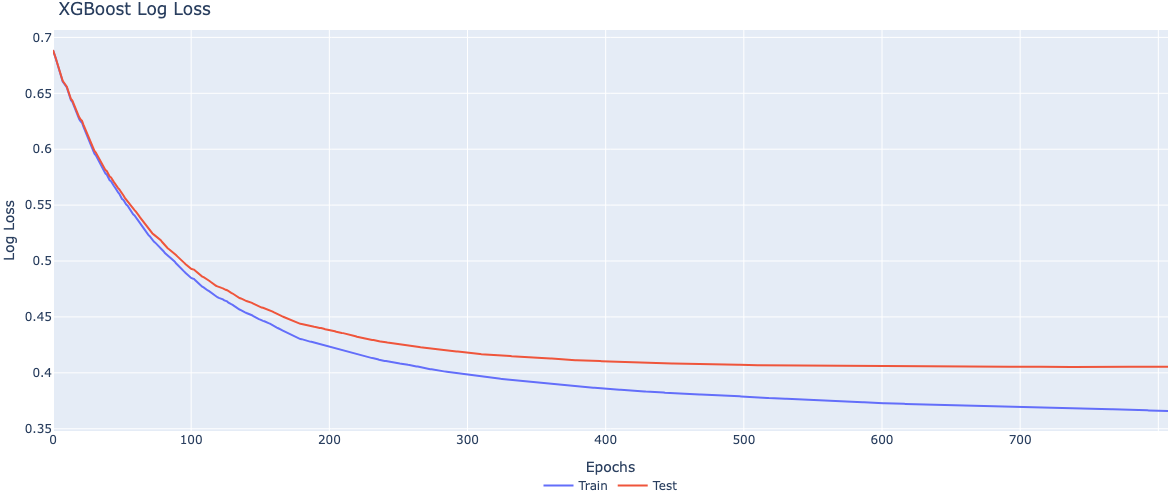

In [543]:
results = xgb_model.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = list(range(0, epochs))

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=results["validation_0"]["logloss"],  name='Train'))
fig.add_trace(go.Scatter(x=x_axis, y=results["validation_1"]["logloss"], name='Test'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="XGBoost Log Loss",
                  xaxis_title="Epochs",
                  yaxis_title="Log Loss",
                  margin=dict(l=0, r=0, t=30, b=0),
                 width=900,
                height=500,)
fig.show()

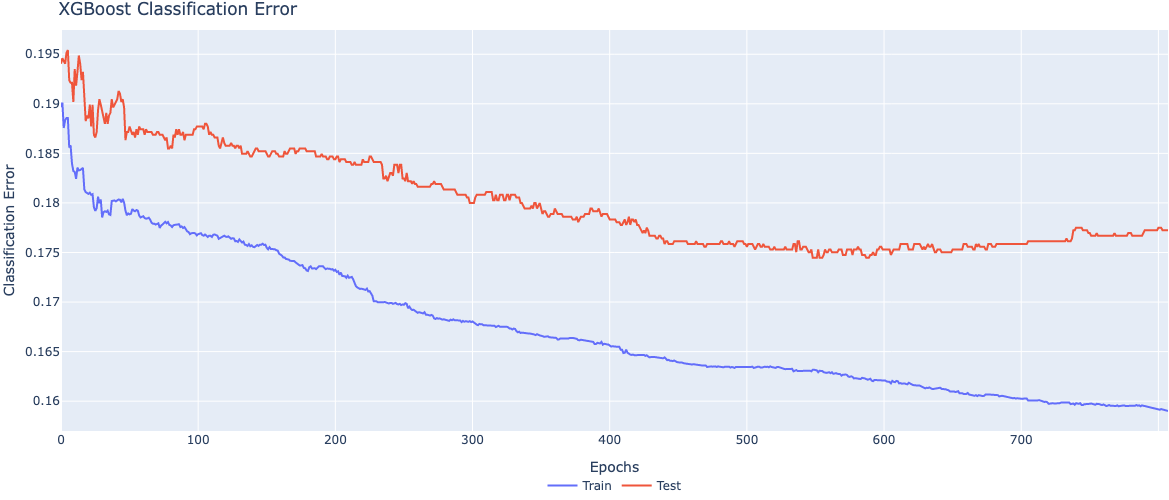

In [544]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=results["validation_0"]["error"],  name='Train'))
fig.add_trace(go.Scatter(x=x_axis, y=results["validation_1"]["error"], name='Test'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="XGBoost Classification Error",
                  xaxis_title="Epochs",
                  yaxis_title="Classification Error",
                  margin=dict(l=0, r=0, t=30, b=0),
                 width=900,
                height=500,)
fig.show()

## Посмотрим на feature importance

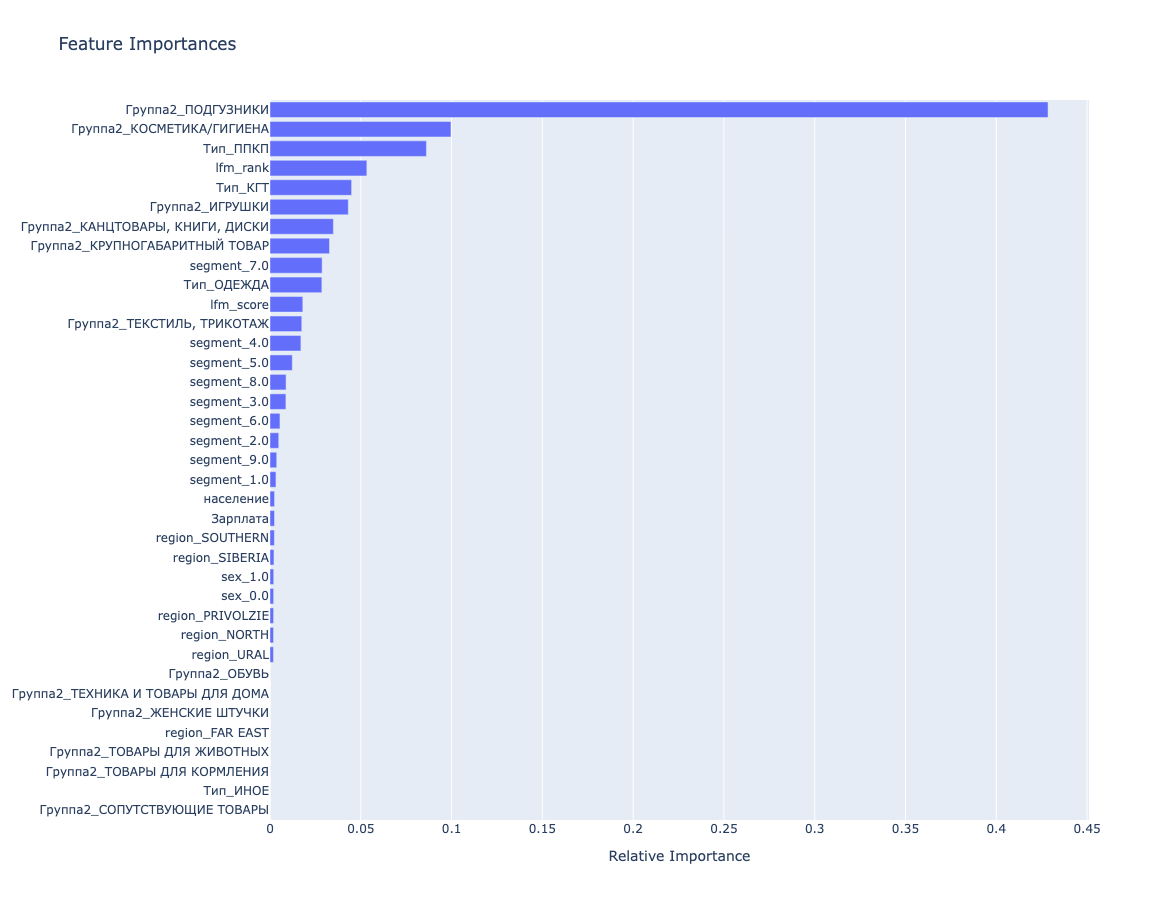

In [398]:
import plotly.graph_objects as go

features = X_train.columns
importances = xgb_model.feature_importances_
indices = np.argsort(importances)


fig = go.Figure(go.Bar(
            x=importances[indices],
            y=[features[i] for i in indices],
            orientation='h',

            ))

fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    title='Feature Importances',
    xaxis_title='Relative Importance'
    )

fig.show()

In [399]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgb_model, np.ascontiguousarray(X_test), y_test, n_repeats=10, random_state=1)
sorted_idx = perm_importance.importances_mean.argsort()

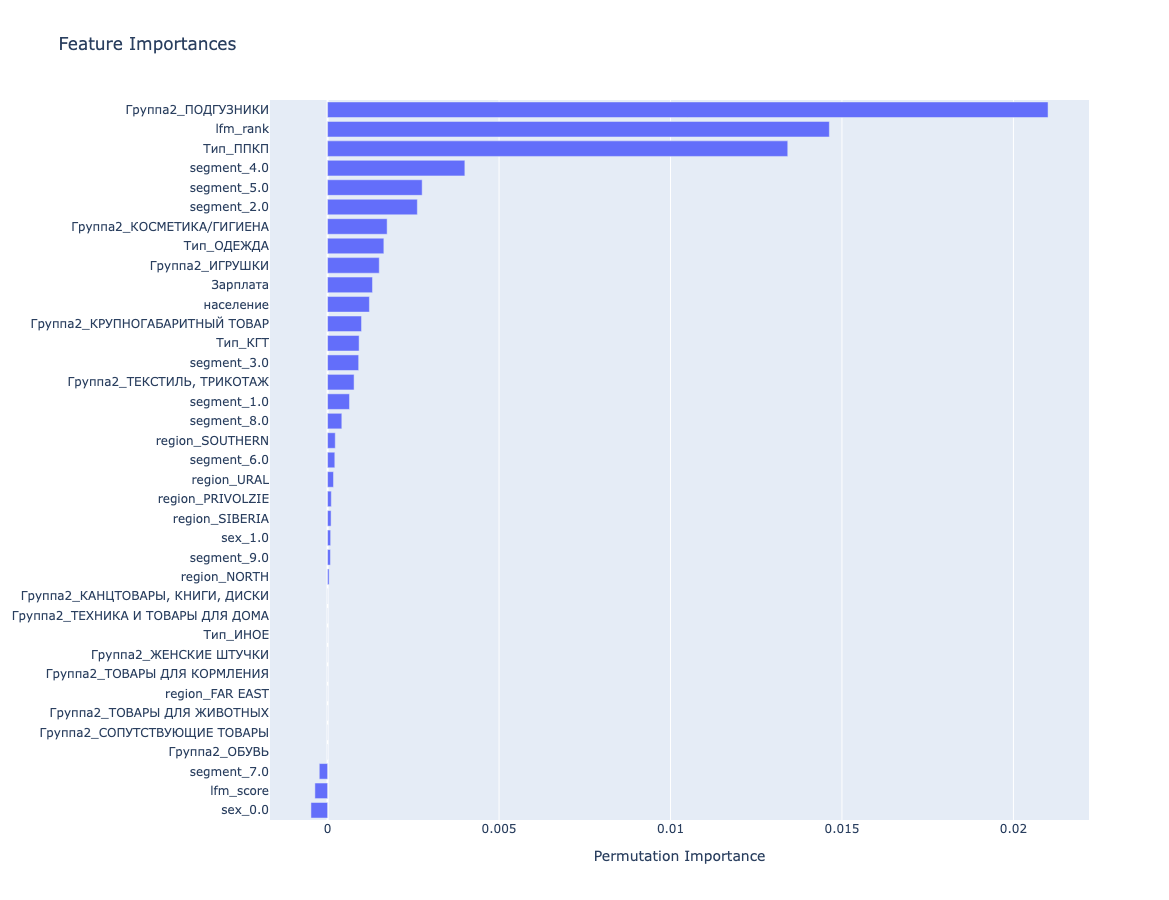

In [400]:
fig = go.Figure(go.Bar(
            x=perm_importance.importances_mean[sorted_idx],
            y=np.array(X_test.columns)[sorted_idx],
            orientation='h',

            ))

fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    title='Feature Importances',
    xaxis_title='Permutation Importance'
    )

fig.show()

## Оценим метрики xgb модели 

In [43]:
test_feat = ctb_test.merge(stat_user_features,
                           on=['user_id'],
                           how='left')\
                    .merge(stat_item_features,
                               on=['item_id'],
                               how='left')

In [44]:
# fillna for catboost with the most frequent value 
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [45]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [49]:
y_pred_ctb = xgb_model.predict_proba(X_test)

In [487]:
from sklearn.metrics import roc_auc_score

f"ROC AUC score = {roc_auc_score(y_test, y_pred_ctb[:, 1]):.2f}"

'ROC AUC score = 0.80'

# Метрики качества на глобальном test

- Формируем рекомендации отдельно моделью 1 этапа - LightFM
- Отдельно двухэтапной моделью LightFM + Catboost 
- Сравниваем


In [50]:
lfm_ctb_prediction = lfm_prediction.copy()

# фичи для теста
score_feat = lfm_ctb_prediction.merge(stat_user_features,
                                   on=['user_id'],
                                   how='left')\
                                .merge(stat_item_features,
                                       on=['item_id'],
                                       how='left')

# fillna for catboost with the most frequent value 
score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [51]:
# catboost predict_proba
xgb_prediction = xgb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))
lfm_ctb_prediction['xgb_pred'] = xgb_prediction[:, 1]

In [52]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['user_id', 'xgb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_xgb'] = lfm_ctb_prediction.groupby('user_id').cumcount() + 1

In [548]:
# # интересно сравнить ранки 1 этапа lightfm и двухэтапной модели
# pd.crosstab(lfm_ctb_prediction[lfm_ctb_prediction['rank'] <= 10]['rank'], 
#             lfm_ctb_prediction[lfm_ctb_prediction['rank_ctb'] <= 10]['rank_ctb'])\
#     .style.background_gradient(cmap='spring')

In [ ]:
test[['user_id', 'item_id']].shape, test[['user_id', 'item_id']].drop_duplicates().shape

In [549]:
model_2step_metrics_ctb = compute_metrics(test[['user_id', 'item_id']],
                                       lfm_ctb_prediction, 
                                       top_N=10, 
                                       rank_col='rank_xgb')
model_2step_metrics_ctb

Precision@1     0.227259
Recall@1        0.095387
Precision@2     0.214869
Recall@2        0.174228
Precision@3     0.193210
Recall@3        0.238418
Precision@4     0.169387
Recall@4        0.268047
Precision@5     0.149471
Recall@5        0.286878
Precision@6     0.133323
Recall@6        0.300414
Precision@7     0.119717
Recall@7        0.309900
Precision@8     0.108870
Recall@8        0.318054
Precision@9     0.099527
Recall@9        0.324715
Precision@10    0.092747
Recall@10       0.334127
MAP@10          0.214799
MRR             0.366571
dtype: float64

In [550]:
df_metrics = pd.concat([
    pd.DataFrame(lfm_metrics).transpose(),
    pd.DataFrame(model_2step_metrics_ctb).transpose()
])

df_metrics.index = ['lightfm', 'model_2step_xgb']

,Precision@1,Recall@1,Precision@2,Recall@2,Precision@3,Recall@3,Precision@4,Recall@4,Precision@5,Recall@5,...,Precision@7,Recall@7,Precision@8,Recall@8,Precision@9,Recall@9,Precision@10,Recall@10,MAP@10,MRR
lightfm,0.211544,0.094238,0.189785,0.163626,0.131359,0.167831,0.115594,0.183549,0.097129,0.195141,...,0.077537,0.208051,0.076496,0.224017,0.069810,0.226979,0.063252,0.227697,0.177067,0.325530
model_2step_xgb,0.227259,0.095387,0.214869,0.174228,0.193210,0.238418,0.169387,0.268047,0.149471,0.286878,...,0.119717,0.309900,0.108870,0.318054,0.099527,0.324715,0.092747,0.334127,0.214799,0.366571


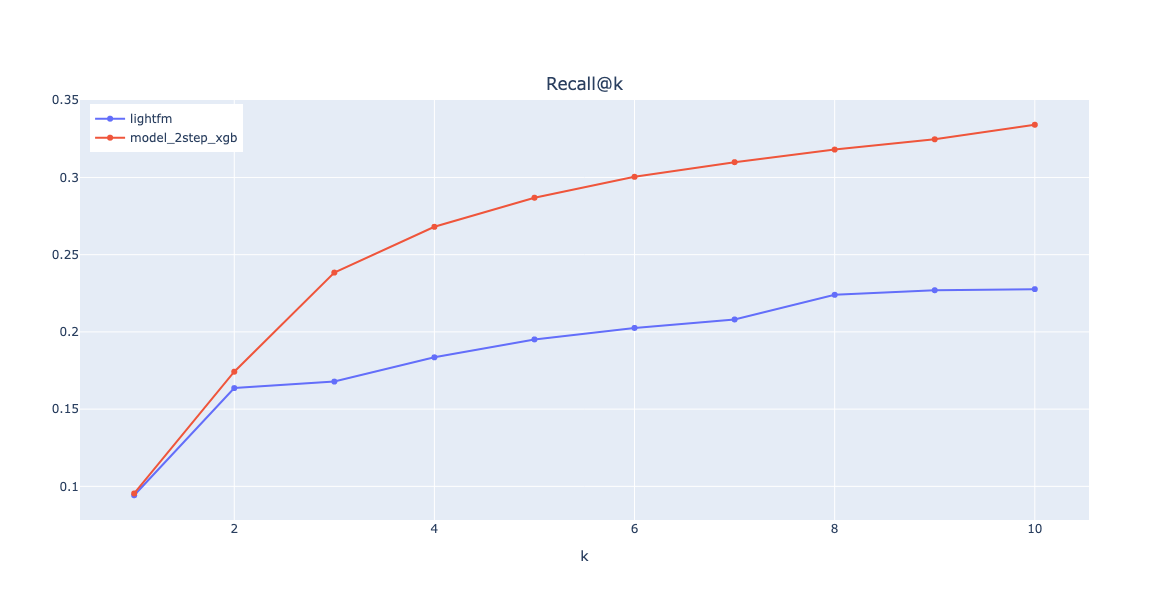

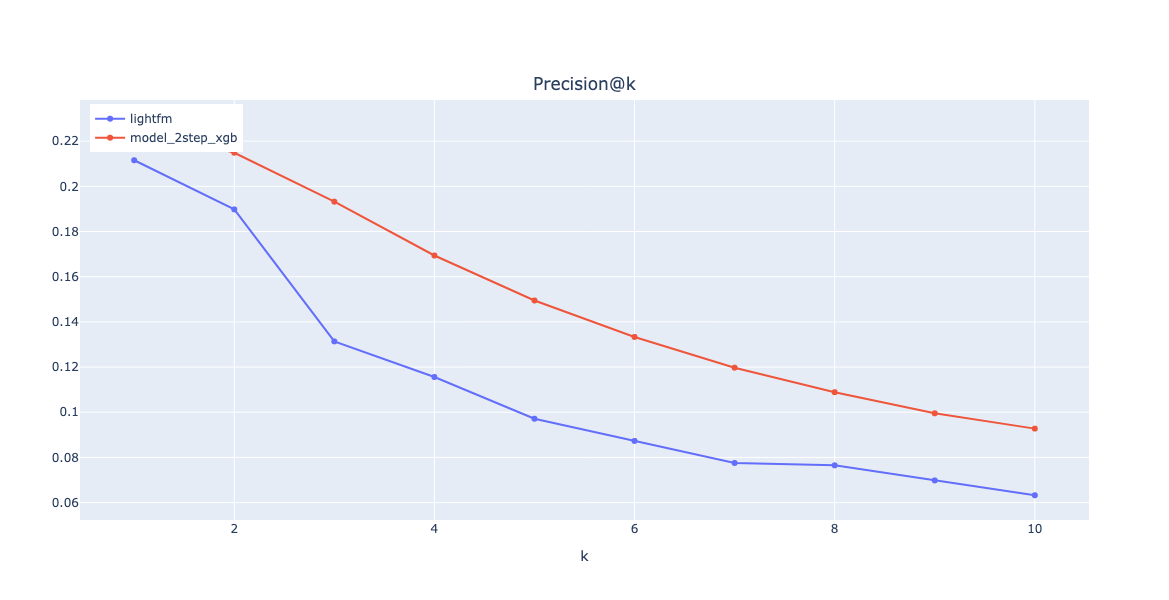

In [553]:
for indx, metric in enumerate([f'Recall@', f'Precision@']):
    fig = go.Figure()
    for model in df_metrics.index:
        fig.add_trace(go.Scatter(
                                x=list(range(1, 11)), 
                                y=df_metrics.loc[model][[metric+f'{k}' for k in range(1, 11)]].values,
                                name=model))
    fig.update_layout(
                      title=dict(text=f'{metric}k', font=dict(size=17)),
                      xaxis_title="k",
                      width=700,
                      height=600,
                      title_x=0.5,
                      title_y=0.87,
                    legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.01))
    fig.show()